Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Streaming output truncated to the last 5000 lines.
Epoch 3/1000
230/230 [==============================] - 2s 9ms/step - loss: 0.1216 - accuracy: 0.9914 - val_loss: 2.4828 - val_accuracy: 0.9569
Epoch 4/1000
230/230 [==============================] - 2s 10ms/step - loss: 0.0453 - accuracy: 0.9948 - val_loss: 2.3485 - val_accuracy: 0.9637
Epoch 5/1000
230/230 [==============================] - 2s 10ms/step - loss: 0.0527 - accuracy: 0.9962 - val_loss: 2.4754 - val_accuracy: 0.9583
Epoch 6/1000
230/230 [==============================] - 2s 9ms/step - loss: 0.0510 - accuracy: 0.9952 - val_loss: 2.6286 - val_accuracy: 0.9596
Epoch 7/1000
230/230 [==============================] - 2s 7ms/step - loss: 0.0555 - accuracy: 0.9951 - val_loss: 2.7302 - val_accuracy: 0.9549
Epoch 8/1000
230/230 [==============================] - 2s 7ms/step - loss: 0.0489 - accuracy: 0.9965 - val_loss: 2.7775 - val_accuracy: 0.9603
Epoch 9/1000
230/230 [==============================] - 2s 8ms/step - loss: 0.0250 

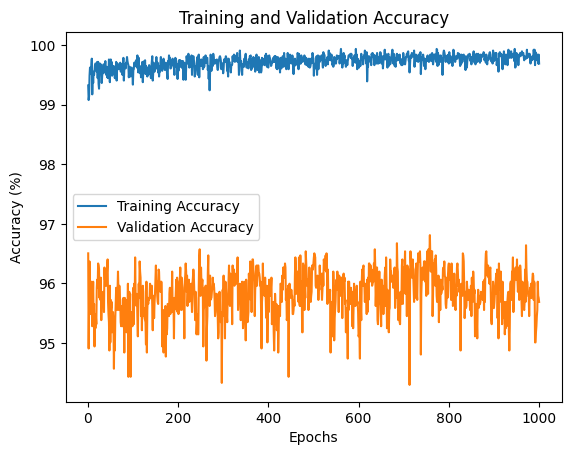

93/93 [==============================] - 0s 4ms/step - loss: 9.3520 - accuracy: 0.9569
Test loss: 9.352012634277344
Test accuracy: 0.9569053053855896


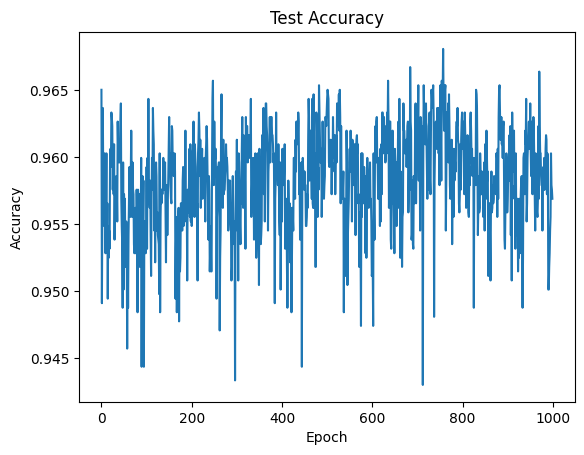

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import zipfile
import io
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

from matplotlib import ticker as mtick
from google.colab import drive
drive.mount('/content/gdrive')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load UCI HAR dataset
with zipfile.ZipFile("/content/gdrive/MyDrive/UCI HAR Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/tmp/har")

x_train = np.loadtxt('/tmp/har/UCI HAR Dataset/train/X_train.txt')
y_train = np.loadtxt('/tmp/har/UCI HAR Dataset/train/y_train.txt').astype(int)
x_test = np.loadtxt('/tmp/har/UCI HAR Dataset/test/X_test.txt')
y_test = np.loadtxt('/tmp/har/UCI HAR Dataset/test/y_test.txt').astype(int)

# Convert labels to one-hot encoding
train_labels = keras.utils.to_categorical(y_train - 1)
test_labels = keras.utils.to_categorical(y_test - 1)

# Normalize features
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# Convert data to TensorFlow datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels)).batch(batch_size)

# Define model architecture
model = Sequential([
    Dense(256, input_shape=(x_train.shape[1],)),
    LeakyReLU(alpha=0.2),
    Dropout(0.5),
    Dense(128),
    LeakyReLU(alpha=0.2),
    Dropout(0.5),
    Dense(train_labels.shape[1], activation='softmax')
])


# Define loss function and optimizer
loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(lr=0.001)
def get_thresholds(gradients):
    thresholds = []
    for gradient in gradients:
        if gradient is not None:
            mean = tf.math.reduce_mean(tf.abs(gradient))
            std = tf.math.reduce_std(tf.abs(gradient))
            threshold = mean + std
            thresholds.append(threshold)
        else:
            thresholds.append(None)
    return thresholds
def generate_adversarial_example(model, x, y, eps=0.1):
    # Use the Fast Gradient Sign Method (FGSM) to generate adversarial example
    loss_fn = keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        loss = loss_fn(y, logits)
    gradients = tape.gradient(loss, x)
    gradients_sign = tf.sign(gradients)
    x_adv = x + eps * gradients_sign
    x_adv = tf.clip_by_value(x_adv, -1, 1)
    return x_adv

@tf.function
def train_step(x, y):
    # Generate adversarial example
    x_adv = generate_adversarial_example(model, x, y)
    # Concatenate original and adversarial examples
    x_combined = tf.concat([x, x_adv], axis=0)
    y_combined = tf.concat([y, y], axis=0)
    with tf.GradientTape() as tape:
        # Forward pass
        logits = model(x_combined, training=True)
        # Compute loss
        loss_value = loss_fn(y_combined, logits)
    # Mask gradients
    gradients = tape.gradient(loss_value, model.trainable_weights)
    thresholds = get_thresholds(gradients)
    masked_gradients = []
    for gradient, threshold in zip(gradients, thresholds):
        if gradient is not None:
            masked_gradient = tf.where(tf.abs(gradient) < threshold, tf.zeros_like(gradient), gradient)
            masked_gradients.append(masked_gradient)
        else:
            masked_gradients.append(None)
    # Apply gradients
    optimizer.apply_gradients(zip(masked_gradients, model.trainable_weights))

# Compile model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
# Train model with adversarial training
epochs = 1000
for epoch in range(epochs):
    for batch_x, batch_y in train_dataset:
        train_step(batch_x, batch_y)

    # Evaluate model on test dataset
    test_loss, test_acc = model.evaluate(test_dataset)

    # Print test accuracy as a percentage with two decimal places
    print('Epoch {}/{} - Test accuracy: {:.2%}'.format(epoch+1, epochs, test_acc))

    # Train model on adversarial examples
    for batch_x, batch_y in train_dataset:
        # Generate adversarial example
        x_adv = generate_adversarial_example(model, batch_x, batch_y)
        # Concatenate original and adversarial examples
        x_combined = tf.concat([batch_x, x_adv], axis=0)
        y_combined = tf.concat([batch_y, batch_y], axis=0)
        model.train_on_batch(x_combined, y_combined)




# Train model and obtain history object
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)
# Generate FGSM adversarial examples
eps = 0.1  # Perturbation size
adv_x_test = generate_adversarial_example(model, tf.convert_to_tensor(x_test), test_labels, eps=eps)


# Evaluate accuracy on original test set
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy on original test set: {:.2f}%'.format(test_acc * 100))

# Evaluate accuracy on FGSM adversarial examples
adv_dataset = tf.data.Dataset.from_tensor_slices((adv_x_test, test_labels)).batch(batch_size)
adv_loss, adv_acc = model.evaluate(adv_dataset)
print('Accuracy on FGSM adversarial examples: {:.2f}%'.format(adv_acc * 100))

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('Accuracy: {:.2%}'.format(history.history['accuracy'][epoch]))
    print('Validation accuracy: {:.2%}'.format(history.history['val_accuracy'][epoch]))
# Extract accuracy and validation accuracy from history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Convert accuracy values to percentages
accuracy_percent = [a * 100 for a in accuracy]
val_accuracy_percent = [v * 100 for v in val_accuracy]




# Plot accuracy and validation accuracy over epochs
plt.plot(range(1, epochs+1), accuracy_percent, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracy_percent, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
adv_acc_percent = adv_acc * 100
test_loss, test_acc = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
# Extract test accuracy values from history object
test_acc = history.history['val_accuracy']

# Plot test accuracy over epochs
plt.plot(test_acc)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

